# Performance Co-Pilot Dataset and TreeTop model evaluation

In [1]:
import copy
import math
import shap
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from IPython.display import clear_output, Image
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.feature_selection import VarianceThreshold, mutual_info_regression

In [2]:
# https://github.com/mljar/mljar-supervised
# pip install mljar-supervised

from supervised.automl import AutoML

In [3]:
# https://github.com/mattiacarletti/DIFFI
# no pip install, requires git clone and local setup, e.g.
# ln -s DIFFI/interpretability_module.py interpretability_module.py
# ln -s DIFFI/sklearn_mod_functions.py sklearn_mod_functions.py
# ln -s DIFFI/utils.py utils.py
# latest scikit-learn requires minor patches (see DIFFI github)

import interpretability_module as interp
from utils import local_diffi_batch

This notebook can be used for modelling purposes only or for modelling with basic 'treetop' reporting UI (console).

The first mode is enabled by setting delay to zero here, otherwise it runs in the second mode.

In [4]:
#delay = 0.5  # updating console
delay = 0  # full modelling mode

verbose = (delay == 0)  # quiet diagnostics if emulating console 'treetop' utility

Using dataset containing system performance metrics from production servers:  
https://github.com/performancecopilot/pcp-datasets

In [5]:
datasets = '../pcp-datasets/'

In [6]:
def prepare_dataset(filename):
    df = pd.read_parquet(filename)
    df = df.select_dtypes(include=['number', 'datetime'])  # remove string metrics
    df = df.dropna(axis=1, how='all')  # remove metrics with no values at all
    print(filename, 'has shape:', df.shape)
    print(df.shape[0], 'samples,', df.shape[1], 'metrics')
    #df.describe()
    return df

Select one of four datasets in the following cells - performance data from either a Java application, a NAS server, SQL Server database or a HPC supercomputing cluster.

In [267]:
def load_app_dataset():
    """ Java web application server performance """
    df = prepare_dataset(datasets + 'hugepage/app3/20120510.parquet')

    # application response time as model target 
    targets = ['webapp.response_time.adjavg[mel]']
          # RED method -> Rate, Error, Duration ('adjavg' metric above is an example of Duration)
          # RED: 'webapp.response_time.samples[mel]' (rate), 'webapp.exception.errorpage' (error)

    # 3 variations on the response time metric exist: adjavg, avg and median; drop closely correlated
    # metrics.  ultimately, this will need to be user-configurable (beyond this prototype modelling).
    notrain = ['webapp.response_time.avg[mel]', 'webapp.response_time.median[mel]']
    notrain.extend(['webapp.response_time.max[mel]', 'webapp.response_time.samples[mel]'])
    return df, 'APP', targets, notrain

#df, dataset, targets, notrain = load_app_dataset()

../pcp-datasets/hugepage/app3/20120510.parquet has shape: (5777, 8400)
5777 samples, 8400 metrics


In [335]:
def load_nas_dataset():
    """ Linux Network Attached Storage server performance """
    df = prepare_dataset(datasets + 'hugepage/nas2/20120510.parquet')
    targets = ['disk.all.avactive']

    # drop obvious contributors with no explanatory value
    notrain = ['disk.all.aveq']
    notrain.extend(['disk.all.read', 'disk.all.blkread', 'disk.all.read_bytes'])
    notrain.extend(['disk.all.total', 'disk.all.blktotal', 'disk.all.total_bytes'])
    notrain.extend(['disk.all.write', 'disk.all.blkwrite', 'disk.all.write_bytes'])
    return df, 'NAS', targets, notrain

#df, dataset, targets, notrain = load_nas_dataset()

../pcp-datasets/hugepage/nas2/20120510.parquet has shape: (5857, 704)
5857 samples, 704 metrics


In [368]:
def load_sql_dataset():
    """ Windows SQL Server database server performance """
    df = prepare_dataset(datasets + 'tempdb/20090106.parquet')
    #df = prepare_dataset('tempdb/20090113.parquet')
    targets = ['sqlserver.databases.all.transactions']
    notrain = ['sqlserver.databases.db.transactions[mel]']
    return df, 'SQL', targets, notrain

df, dataset, targets, notrain = load_sql_dataset()

../pcp-datasets/tempdb/20090106.parquet has shape: (5764, 242)
5764 samples, 242 metrics


In [300]:
def load_hpc_dataset():
    """ HPC supercomputer cluster performance """
    df = prepare_dataset(datasets + 'marconi100/20220901.parquet')
    node_temp = [x for x in df.columns if x.startswith('ipmi.ambient_temp')]
    node_power = [x for x in df.columns if x.startswith('ipmi.total_power')]
    df['ipmi.total_power'] = df[node_power].sum(axis=1)

    # power usage as model target 
    targets = ['ipmi.total_power']
    notrain = node_power + node_temp
    return df, 'HPC', targets, notrain

#df, dataset, targets, notrain = load_hpc_dataset()

../pcp-datasets/marconi100/20220901.parquet has shape: (4320, 25629)
4320 samples, 25629 metrics


## Isolation Forest anomaly exploration (unsupervised learning and explanation)

In [11]:
import matplotlib.dates as mdates

def prepare_plot():
    fig, axs = plt.subplots(figsize=(16, 2))
    minutes_locator = mdates.MinuteLocator(interval=30)
    minutes_formatter = mdates.DateFormatter('%H:%M')
    axs.xaxis.set_major_formatter(minutes_formatter)
    axs.xaxis.set_major_locator(minutes_locator)
    fig.autofmt_xdate()
    plt.xlabel("Time of day")  # custom x label using Matplotlib
    return fig, axs

In [12]:
def isolation_forest(X, contamination='auto'):
    iso = IsolationForest(contamination=contamination, bootstrap=False)  # train with replacement
    X0 = X.fillna(0)
    y_pred = iso.fit(X0).predict(X0)
    y_pred_diffi = np.array(iso.decision_function(X0) < 0).astype('int')
    return iso, y_pred, y_pred_diffi, X0

In [13]:
def top_N_anomaly_features(iso, y_pred_diffi, X0, N):
    """ pick top N-most anomalous features and project back onto original columns/shape """
    fit = X0.to_numpy()[np.where(y_pred_diffi == 1)]

    diffi, ord_idx_diffi, exec_time_diffi = local_diffi_batch(iso, fit)

    if verbose:
        print('Average computational time Local-DIFFI:', round(np.mean(exec_time_diffi), 5))
        print('Total computational time Local-DIFFI:', round(np.sum(exec_time_diffi), 5))
        #print('DIFFI shape', diffi.shape, 'rank:\n', pd.DataFrame(diffi))

    # use DIFFI anomaly values to find the features contributing most to anomalies
    rank_df = pd.DataFrame(diffi).sum().nlargest(N, keep='all')
    #if verbose: print('DIFFI ranking:\n', rank_df.index)   # feature indices

    # dictionary of keys: anomalies-feature_name and values: array of DIFFI scores
    frame = {}
    for i in rank_df.index:   # column index (original features), from ranking
        key = 'anomalies-' + X0.columns[i]
        value = [0] * X0.shape[0]   # zero-filled array
        # fill in just the anomaly values now (replacing zeroes)
        for diffi_index, value_index in enumerate(np.where(y_pred_diffi == 1)[0]):
            value[value_index] = diffi[diffi_index][i]
            #print('value_index:', X_index, 'diffi_index:', diffi_index, 'value =', diffi[diffi_index][i])
        frame[key] = value

    anomaly_X = pd.DataFrame(data=frame, dtype='float64')
    #if verbose: anomaly_X.describe()

    return anomaly_X, diffi, ord_idx_diffi

In [14]:
# list available aggregate processor (CPU) metrics
for c in df.columns:
    pattern = 'kernel.all.cpu'
    if c[0:len(pattern)] == pattern: print(c)

kernel.all.cpu.user
kernel.all.cpu.nice
kernel.all.cpu.sys
kernel.all.cpu.idle
kernel.all.cpu.intr
kernel.all.cpu.wait.total
kernel.all.cpu.irq.soft
kernel.all.cpu.irq.hard
kernel.all.cpu.steal
kernel.all.cpu.guest


In [15]:
data = df[["timestamp", "kernel.all.cpu.sys", "kernel.all.cpu.user", "kernel.all.cpu.intr"]]
# perform unit conversion to seconds on CPU timeseries for neater graphing (usec on Windows)
# note: HPC dataset is missing the interrupt metric so cannot be used here
if 'sqlserver.connections' in df.columns:
    convert = 1e-06  # usec
else:
    convert = 1e-03  # msec
data.loc[:, ('kernel.all.cpu.sys', 'kernel.all.cpu.user', 'kernel.all.cpu.intr')] *= convert
data.head()

,timestamp,kernel.all.cpu.sys,kernel.all.cpu.user,kernel.all.cpu.intr
0,2012-05-10 00:13:27.614512,NaN,NaN,NaN
1,2012-05-10 00:13:42.614512,NaN,NaN,NaN
2,2012-05-10 00:13:57.614512,0.110133,1.089400,0.010133
3,2012-05-10 00:14:12.614512,0.183133,0.955467,0.011067
4,2012-05-10 00:14:27.614512,0.166067,0.890400,0.009933


In [16]:
# sample time series for some exploratory analysis and visualisation of anomalies
X = data.loc[:, ('kernel.all.cpu.sys', 'kernel.all.cpu.user', 'kernel.all.cpu.intr')]
X.describe()

,kernel.all.cpu.sys,kernel.all.cpu.user,kernel.all.cpu.intr
count,5771.000000,5771.000000,5771.000000
mean,0.288640,3.537380,0.101164
std,0.995544,2.745037,0.078509
min,0.061600,0.039667,0.000667
25%,0.144233,1.153600,0.026600
50%,0.215867,2.585333,0.087267
75%,0.301567,6.179733,0.174433
max,23.889600,19.047467,0.401867


In [17]:
outliers_fraction = 0.0125  # reduce 'auto' default set (full day of data)
isotree, y_pred, y_pred_diffi, X0 = isolation_forest(X, outliers_fraction)

print('Detected anomalies:', int(sum(y_pred_diffi)), 'out of', len(y_pred_diffi), 'samples')
#print(y_pred_diffi.shape)

Detected anomalies: 73 out of 5777 samples


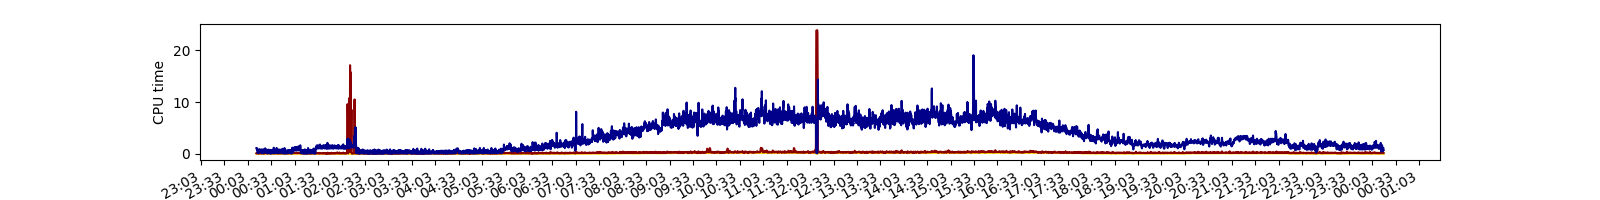

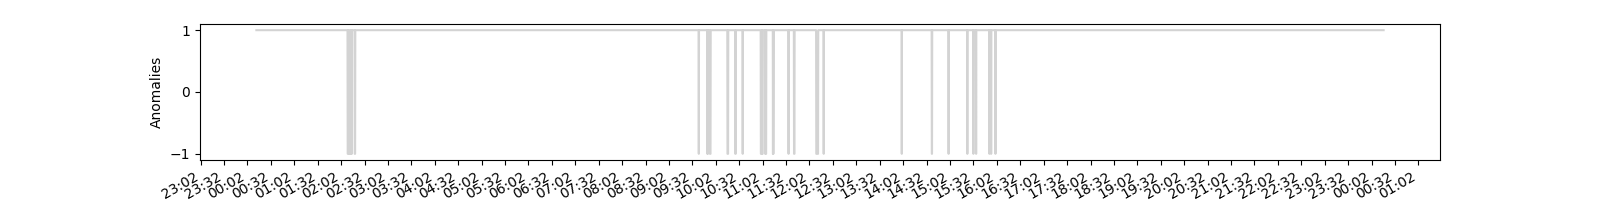

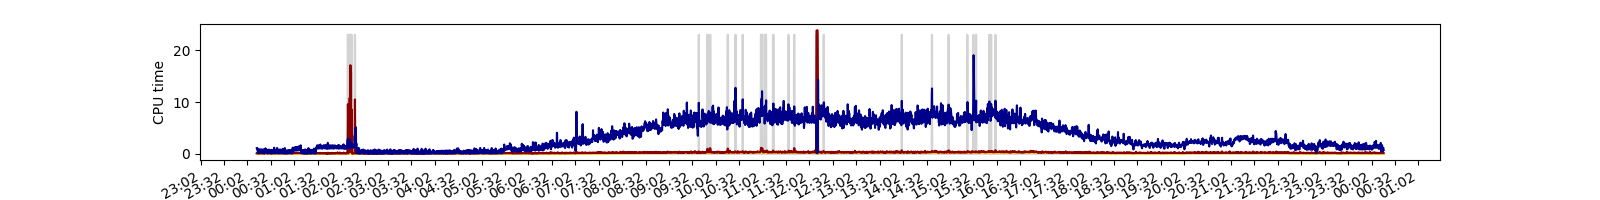

In [18]:
def plot_anomalies_cpu(filename, y_pred, data):
    path = 'images/'

    # raw time series
    fig, axs = prepare_plot()
    axs.plot(data['timestamp'], data['kernel.all.cpu.intr'], color="gold")  # interrupt time
    axs.plot(data['timestamp'], data['kernel.all.cpu.sys'], color="darkred")  # time in the kernel (non-interrupt)
    axs.plot(data['timestamp'], data['kernel.all.cpu.user'], color="darkblue")  # time spent in userspace
    plt.ylabel("CPU time")
    plt.savefig(path + 'base' + filename)
    plt.close("all")

    # raw anomalies
    fig, axs = prepare_plot()
    axs.plot(data['timestamp'], y_pred, color="lightgray")  # anomaly labels
    plt.ylabel("Anomalies")
    plt.savefig(path + 'isotree' + filename)
    plt.close("all")

    # super-imposed
    limit0 = np.max(data['kernel.all.cpu.sys'])
    limit1 = np.max(data['kernel.all.cpu.user'])
    limit2 = np.max(data['kernel.all.cpu.intr'])
    y_pred[y_pred == 1] = 0  # ordinary data points
    y_pred[y_pred != 0] = max(limit0, limit1, limit2)  # anomalies
    
    fig, axs = prepare_plot()
    axs.plot(data['timestamp'], y_pred, color="lightgray")  # anomaly labels
    axs.plot(data['timestamp'], data['kernel.all.cpu.intr'], color="gold")  # interrupt time
    axs.plot(data['timestamp'], data['kernel.all.cpu.sys'], color="darkred")  # time in the kernel (non-interrupt)
    axs.plot(data['timestamp'], data['kernel.all.cpu.user'], color="darkblue")  # time spent in userspace
    plt.ylabel("CPU time")
    plt.savefig(path + 'superimposed' + filename)
    plt.close("all")

plot_anomalies_cpu('_cpu_anomalies.png', y_pred, data)
display(Image(filename='images/base_cpu_anomalies.png'))
display(Image(filename='images/isotree_cpu_anomalies.png'))
display(Image(filename='images/superimposed_cpu_anomalies.png'))

In [19]:
anomaly_X, _, ord_idx_diffi = top_N_anomaly_features(isotree, y_pred_diffi, X0, N=2)

Average computational time Local-DIFFI: 0.01056
Total computational time Local-DIFFI: 0.7709


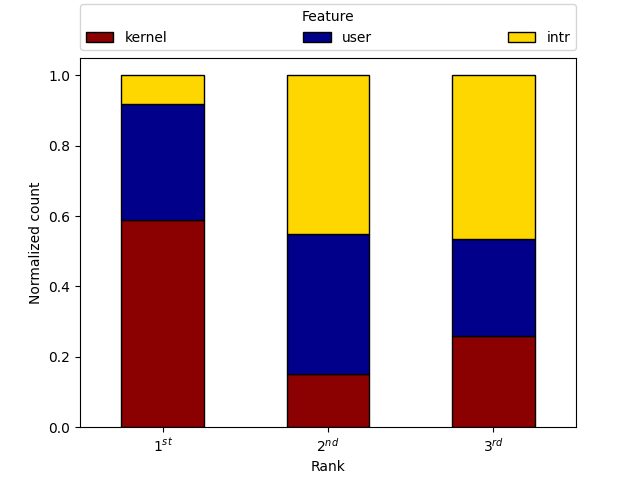

In [20]:
def plot_ranking_cpu(filename, ord_idx, title):
    id2feat = {0:'kernel', 1:'user', 2:'intr'}
    colours = ['darkred', 'darkblue', 'gold']
    x_ticks = [r'$1^{st}$', r'$2^{nd}$', r'$3^{rd}$']
    num_feats = ord_idx.shape[1]
    features = np.arange(num_feats)
    ranks = np.arange(1, num_feats + 1)
    rank_features = {r: [list(ord_idx[:,r-1]).count(f) for f in features] for r in ranks}
    df = pd.DataFrame(rank_features)
    df_norm = df.transform(lambda x: x / sum(x))
    df_norm['Feature ID'] = features
    df_norm['Feature'] = df_norm['Feature ID'].map(id2feat)
    df_norm.drop(['Feature ID'], inplace=True, axis=1)
    df_norm.set_index('Feature').T.plot(kind='bar', stacked=True, color=colours, edgecolor='black')
    locs, labels = plt.xticks()
    plt.ylim((0, 1.05))
    plt.xticks(locs, x_ticks, rotation=0)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', title='Feature', ncol=6, mode='expand', borderaxespad=0.0)
    plt.xlabel('Rank')
    plt.ylabel('Normalized count')
    plt.title(title, y=1.15)
    plt.savefig(filename)
    plt.close("all")

title = 'Feature ranking CPU series outliers - Local DIFFI - full day'
plot_ranking_cpu('images/diffi_cpu_series_ranking.png', ord_idx_diffi, title=title)
display(Image(filename='images/diffi_cpu_series_ranking.png'))

In [21]:
def anomaly_features(X, metrics, outliers_fraction='auto', N=25):   # add up to N anomaly features
    """ feature engineering wrapper for primary model building later """
    t0 = time.time()
    isotree, y_pred, y_pred_diffi, X0 = isolation_forest(X, outliers_fraction)
    anomaly_X, diffi, ord_idx_diffi = top_N_anomaly_features(isotree, y_pred_diffi, X0, N)
    t1 = time.time()

    metrics['anomaly_time'] = t1 - t0
    metrics['anomaly_count'] = int(sum(y_pred_diffi))
    metrics['anomaly_features'] = anomaly_X.shape[1]

    return anomaly_X

## Primary model evaluation (supervised learning and explanations)

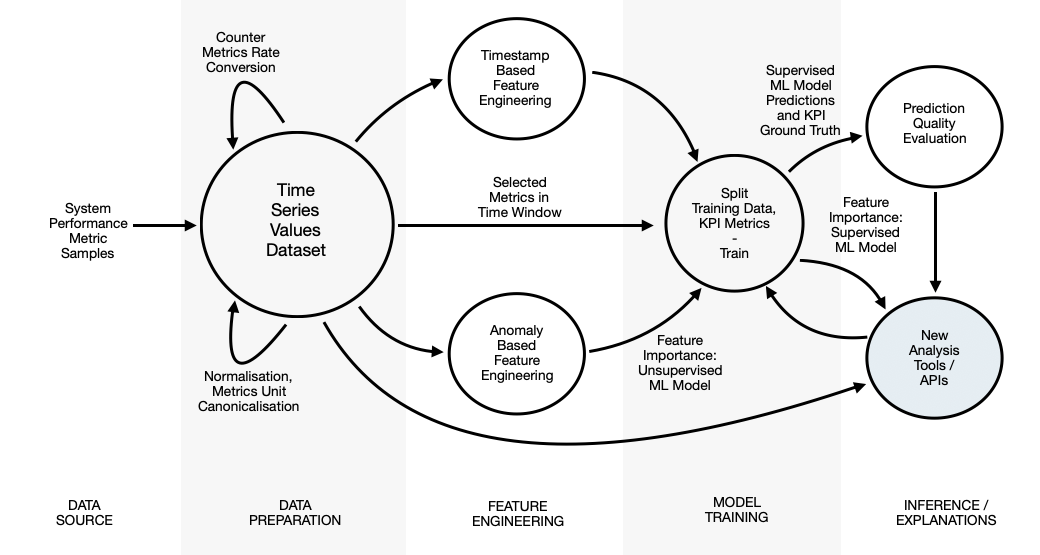

In [22]:
display(Image(filename='images/model-design.png'))

In [369]:
timestamps = df['timestamp']
timeframe = timestamps.iloc[-1] - timestamps.iloc[0]
interval = (timestamps.iloc[1] - timestamps.iloc[0]).total_seconds()
assert interval <= 60 * 10 # set a max of ten minutes for window stepping
print('Dataset timeframe:', timeframe)
print('Sampling interval:', interval, 'seconds')

Dataset timeframe: 1 days 00:00:45
Sampling interval: 15.0 seconds


In [370]:
# training window size parameters
nhours = 2
window = int((nhours * 60 * 60) / interval)  # (15sec interval x 480 samples -> 2 hours) training dataset size
step = int((15 * 60) / interval)   # (15sec interval x 60 samples -> 15 mins) stepping throughout day
assert window < df.shape[0]  # ensure less than total rows
assert window > interval
assert step > interval
assert step < window

start = 0
stop = df.shape[0] - window - 1
#print('start', start, '- stop', stop)
assert stop > start

# prepare list of algorithms to assess and initialize counters to zero
algorithms = ['Baseline', 'CatBoost', 'LightGBM', 'Xgboost', 'Decision Tree', 'Random Forest', 'Extra Trees', 'Linear', 'Neural Network', 'Nearest Neighbors']
if delay != 0:
    algorithms = ['Xgboost'] #['CatBoost'] #['LightGBM'] 

algorithms = ['Xgboost']  # XXX
stop //= 2  # XXX
    
best_algorithm = {}
for algorithm in algorithms:
    best_algorithm[algorithm] = 0
(goal_values, pred_values, loss_values, train_times, time_stamps) = ([], [], [], [], [])

### Helper functions

Global state is setup now, following are modelling and reporting routines.

In [371]:
def automl_evaluation(algorithms, train_X, train_y, time_cv, predict, timestamp):
    """ Build and evaluate model(s) for a single epoch of window sliding """
    if verbose:
        print('automl_evaluation', 'X shape', train_X.shape, 'y shape', train_y.shape)
        verbosity = 1
    else:
        verbosity = 0

    automl = AutoML(
        algorithms=algorithms,
        train_ensemble=False,
        explain_level=1,
        verbose=verbosity,
        results_path='results/' + str(timestamp).replace(" ", "_"),

        # depending on target (ml_task), may need to use different evaluation metric here:
        # metrics for binary classification: logloss, auc, f1, average_precision, accuracy
        # metrics for mutliclass classification: logloss, f1, accuracy
        # metrics for regression: rmse, mse, mae, r2, mape, spearman, pearson
        ml_task='regression',
        eval_metric='mae',  # regression, chosen from literature reviewed
        validation_strategy={'validation_type': 'split'}  # time series CV split is used.
    )

    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        automl.fit(train_X, train_y, cv=time_cv)

    return automl

In [372]:
def confidence_level(actual, predicted):
    difference = abs(predicted - actual)
    if difference == 0:
        return 1  # avoid divide-by-zero, highly confident
    return 1.0 - (difference / actual)

In [373]:
def predict_response(model, epoch, timestamp, target, test_X, test_y):
    # use a given model to make a target (response time) prediction

    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        pred_y = model.predict(test_X)

    goal = test_y.iloc[-1][target]
    pred = pred_y[0]

    if verbose:
        diff = confidence_level(goal, pred) * 100.0
        print()
        print('|', epoch, '|', timestamp, '| best model:', automl_model._best_model.get_type())
        print('|', epoch, '|', timestamp, '| observed:', round(float(goal), 2), 'predicted:', round(float(pred), 2), '| confidence:', round(float(diff), 2), '%')
        print()

    return (goal, pred)

In [374]:
def timestamp_features(timestamps):
    """ time features - for each row (each sample) extract timestamp features """
    (second_in_minute, minute_in_hour, hour_in_day, day_of_week) = ([], [], [], [])

    # raw timestamp is removed from training datasets, and replaced with these
    # generic representations that have meaning for cyclic analysis scenarios
    for timestamp in timestamps:
        second_in_minute.append(timestamp.second)
        minute_in_hour.append(timestamp.minute)
        hour_in_day.append(timestamp.hour)
        day_of_week.append(timestamp.dayofweek)

    features = {
        'timestamp-second_in_minute': second_in_minute,
        'timestamp-minute_in_hour': minute_in_hour,
        'timestamp-hour_in_day': hour_in_day,
        'timestamp-day_of_week': day_of_week,
    }
    return pd.DataFrame(data=features)

In [375]:
def reduce_with_variance(train_X):
    """ Automated dimensionality reduction using variance """
    clean_X = train_X.fillna(0)

    t0 = time.time()
    cull = VarianceThreshold(threshold=0.125)
    cull.fit(clean_X)
    t1 = time.time()
    if verbose: print('VarianceThreshold time:', t1-t0)

    keep = cull.get_feature_names_out()
    if verbose: print('Keeping', len(keep), 'of', train_X.shape[1], 'columns with Variance')
    train_X = train_X[keep]
    if verbose: print('VarianceThreshold shape:', train_X.shape)

    metrics['low_variance'] = train_X.shape[1]
    
    return train_X

In [376]:
MAXMI = 1001 # hard limit on features passing from MI selection

def reduce_with_mutual_info(train_y, train_X, metrics):
    """ Automated dimensionality reduction using mutual information """
    clean_X = train_X.fillna(0)
    clean_y = train_y.values.flatten()

    # calculate all features mutual information with the target variable
    t0 = time.time()
    mi = mutual_info_regression(clean_X, clean_y, discrete_features=False, n_jobs=-1)
    mi /= np.max(mi)  # normalise based on largest value observed
    t1 = time.time()
    if verbose: print('MutualInformation time:', t1 - t0)
    if verbose: print('MutualInformation shape', mi.shape)
    
    # stash a dataframe with mutual information of clean columns
    results = {}
    for i, column in enumerate(clean_X.columns):
        results[column] = list([mi[i]])
    metrics['information'] = pd.DataFrame(data=results, dtype='float64')

    cull = mi <= 0.125
    indices = np.where(cull)
    drop_columns = clean_X.columns[indices]
    if verbose:
        keeping = clean_X.shape[1] - len(drop_columns)
        print('Keeping', keeping, 'columns with MutualInformation')
    if len(drop_columns) > MAXMI:  # still too many, reduce via argsort
        # cap the number of features after mutual information;
        # argsort arranges values from smallest to largest MI.
        upuntil = mi.shape[0] - MAXMI
        indices = mi.argsort()[0:upuntil]
        if verbose:
            print('Limit', MAXMI, 'columns with MutualInformation')
    clean_X = clean_X.drop(clean_X.columns[indices], axis=1)
    train_X = train_X[clean_X.columns]  # undo NaN->0
    if verbose: print('MutualInformation shape:', train_X.shape)

    return train_X

In [377]:
def prepare_split(df, start, finish, targets, notrain, metrics, splits=5):
    window = df[start:finish]
    if verbose:
        print('Dimensionality reduction for window', start, '-', finish)
        print('Initial sample @', window.iloc[0]['timestamp'])
        print('Initial shape:', window.shape)
        print('Final sample @', window.iloc[-1]['timestamp'])

    # ensure target metrics (y) values are valid
    window = window.dropna(subset=targets, ignore_index=True)
    metrics['total_features'] = window.shape[1]

    # Automated feature engineering based on time
    times_X = timestamp_features(window['timestamp'])
    if verbose: print('times_X shape:', times_X.shape)
    if verbose: print('times_X index:', times_X.index)

    # remove columns (metrics) requested by user
    columns = copy.deepcopy(notrain)
    if verbose: print('Dropping requested', len(columns), 'columns')
    window_X = window.drop(columns=columns)

    # track columns containing intermittent NaNs to reinstate later
    metrics['missing_values'] = window_X.isna().sum().sum()
    dirty_X = window_X.loc[:, window_X.isnull().any()]
    if verbose: print('dirty_X shape:', dirty_X.shape)

    clean_X = window_X.loc[:, window_X.notnull().all()]
    clean_y = clean_X.loc[:, targets]
    timestr = clean_X.iloc[-1]['timestamp'] # current reporting sample (prediction) timestamp
    clean_X = clean_X.drop(columns=targets)
    clean_X = clean_X.drop(columns=['timestamp'])

    # Automated feature reduction based on variance
    clean_X = reduce_with_variance(clean_X)

    # Automated feature reduction based on mutual information
    clean_X = reduce_with_mutual_info(clean_y, clean_X, metrics)

    # Automated anomaly-based feature engineering
    quirk_X = anomaly_features(clean_X, metrics, N=25)
    if verbose: print('quirk_X shape:', quirk_X.shape)

    # merge reduced set with new features
    clean_X = pd.merge(times_X, clean_X, left_index=True, right_index=True)
    clean_X = pd.merge(clean_X, quirk_X, left_index=True, right_index=True)
    if dirty_X.shape[1] < clean_X.shape[1]/8:  # careful not to wipe selections
        final_X = pd.merge(clean_X, dirty_X, left_index=True, right_index=True)
    else:
        final_X = clean_X
    finish = final_X.shape[0] - 1

    # prepare for cross-validation over the training window
    time_cv = TimeSeriesSplit(gap=0, max_train_size=finish, n_splits=splits, test_size=1)

    # Finally, perform the actual test/train splitting.
    # Next target metric value (y) forms the test set,
    # prediction of this drives explainable AI usage.

    test_X = final_X.iloc[[finish]]     # latest value
    train_X = final_X.iloc[0:finish, :]     # the rest
    test_y = clean_y.iloc[[finish]]
    train_y = clean_y.iloc[0:finish, :]

    if verbose > 1:
        print('Final training y shape:', train_y.shape, 'type:', type(train_y))
        print('Final training X shape:', train_X.shape, 'type:', type(train_X))
        print('Final test set y shape:', test_y.shape, 'type:', type(test_y))
        print('Final test set X shape:', test_X.shape, 'type:', type(test_X))

    # stash latest observed values for reporting
    values = {}
    for column in train_X.columns:
        values[column] = train_X.iloc[-1][column]
    for column in train_y.columns:
        values[column] = train_y.iloc[-1][column]
    metrics['values'] = values

    return (train_X, train_y, test_X, test_y, time_cv, timestr)

In [378]:
def numeric_string(number, format, units=None, minlen=0, maxlen=0):
    """ Helper routine to pretty-print floating point """
    string = format % number
    if '.' in string:
        string = string.rstrip('0')  # remove trailing zeroes
    if string[-1] == '.':
        string = string[:-1]  # remove trailing decimal point
    if minlen > 0 and len(string) < minlen:
        string = string.rjust(minlen)
    if maxlen > 0 and len(string) > maxlen:
        string = string[:maxlen]
    if units:
        string += ' ' + units
    return string

def time_string(seconds):
    """ Human-readable string showing the total time window """
    if seconds > 60 * 60:  # report in units of hours
        return numeric_string(seconds / (60 * 60), "%.2f", "hours")
    if seconds > 60:  # report in units of minutes
        return numeric_string(seconds / (60), "%.2f", "minutes")
    return numeric_string(seconds, "%.3f", "seconds")

In [379]:
def summary(timestamp, window, interval, metrics):
    print('===== Summary =====')

    print('Window size:     ', time_string(window * interval))
    print('Sample interval: ', time_string(interval))
    print('Training samples:', int(window / interval))
    print('Total features:  ', metrics['total_features'])
    print('    Low variance:       ', metrics['low_variance'])
    print('    Missing values:     ', metrics['missing_values'])
    print('    Mutual information: ', metrics['information'].shape[1])
    print('Sampling time:   ', time_string(metrics['sampling_time']))
    print('Training time:   ', time_string(metrics['training_time']))
    print('Confidence:      ', '%.3f%%' % (metrics['confidence'] * 100))

    print()

#### Prepare time window dataframe for each model evaluation iteration, then evaluate.

Keep track of best model and performance over time for subsequent plot generation - this plot characterises best performing models.

Use a sliding window over the entire dataset, re-evaluating models on every step for a single time window.

In [380]:
def feature_importance(automl_model, X, top_N=25):
    learner = automl_model.learners[-1]
    if learner.algorithm_short_name != 'Xgboost':
        return None

    # importance types:  'weight', 'gain', 'cover', 'total_gain', 'total_cover'
    importance = learner.model.get_score(importance_type='gain')

    total = 0
    for value in importance.values():
        total += value

    # first calculate overall percentage contribution for all features
    percents = {}
    for key in importance.keys():
        # remap internal 'fN' (N=index) feature names to their original names
        index = int(key[1:])
        metric = X.columns[index]
        percent = (importance[key] / total) * 100.0
        percents[metric] = percent

    # now pick out N topmost important features
    result = {}
    subtotal = 0
    for i, (metric, percent) in enumerate(sorted(percents.items(), key=lambda item: item[1], reverse=True)):
        result[metric] = percent
        subtotal += percent
        if i >= top_N: break

    # calculate contributions within this subset for reporting
    for key, value in result.items():
        result[key] = (value / subtotal)

    return result

#_ = feature_importance(best_model, train_X, top_N=25)

In [381]:
def shap_feature_importance(automl_model, X, y, top_N=25):
    learner = automl_model.learners[-1]
    if learner.algorithm_short_name != 'Xgboost':
        return None

    explainer = shap.TreeExplainer(learner.model)
    explanation = explainer.shap_values(X).sum(axis=0)
    result = {}
    count = 0
    for i in explanation.argsort():
        metric = train_X.columns[i]
        result[metric] = explanation[i]
        count += 1
        if count >= top_N: break

    return result

#_ = shap_feature_importance(best_model, train_X, train_y, top_N=25)

In [382]:
def treetop(timestamp, targets, X_test, y_test, metrics):
    """ Produces a top(1)-like report showing metrics (features) that explain target variables """
    nw = 50 # feature name width

    print('%-*s' % (nw, '===== Analysis ====='), ' | Latest Value ', '%s @ %s %s |' % (' '*6, timestamp, ' '*6))
    print('%-*s' % (nw, 'Key Performance Indicators:'), ' +'+'-'*14+'+'+'-'*43+'+')

    for target in sorted(targets):
        actual = numeric_string(y_test[target].iloc[0], '%.5f', minlen=10, maxlen=10)
        print('%*s' % (nw, target[-nw:]), ' | ', actual, ' | ', 40*' ', '|')
    print('%*s' % (nw, ''), ' | ', 10 * ' ', ' | Mutual Information  | Feature Importance  |')

    print('%-*s' % (nw, 'Key Explanatory Metrics:'), ' +%s+%s+%s+' % ('-'*14, '-'*21, '-'*21))

    importance = metrics['importance']
    information = metrics['information']

    def report_bar(value):
        """ input is normalised floating point (between zero and one) """
        bar = '█' * math.ceil(value * 10)
        if len(bar) < 10:
            bar += ' ' * (10 - len(bar))
        return bar

    for metric, ranked in sorted(importance.items(), key=lambda item: item[1], reverse=True):

        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            value = X_test[metric].iloc[-1]
        if np.isnan(value):
            value = '- N/A -'.rjust(10)
        else:
            value = numeric_string(value, '%.5f', minlen=10, maxlen=10)

        fibar = report_bar(ranked)
        fi = numeric_string(ranked * 100.0, '%.5f', minlen=7, maxlen=7)

        if metric not in information:  # e.g. engineered feature
            mi = '- N/A -'
            mibar = ' ' * 10
        else:
            mi = information[metric].iloc[-1]
            mibar = report_bar(mi)
            mi = numeric_string(mi, '%.5f', minlen=7)

        name = metric
        if len(name) > (nw-2):
            name = '..' + metric[-(nw-2):]

        print('%*s' % (nw, name), ' | ', value, ' | ', mi, mibar, '| ', fi, fibar, '|')

In [383]:
for epoch, offset in enumerate(range(start, stop, step)):
    predict = offset + window   # index for final row of window
    assert predict < df.shape[0]

    if verbose: print('Epoch:', epoch, 'offset:', offset, 'predict:', predict)

    metrics = {}
    t0 = time.time()
    (train_X, train_y, test_X, test_y, time_cv, timestamp) = prepare_split(df, offset, predict, targets, notrain, metrics)
    t1 = time.time()

    automl_model = automl_evaluation(algorithms, train_X, train_y, time_cv, predict, timestamp)
    (goal, pred) = predict_response(automl_model, epoch, timestamp, targets[0], test_X, test_y)
    best_model = automl_model._best_model

    # update model evaluation metrics for this iteration
    best_algorithm[best_model.get_type()] += 1
    loss_values.append(best_model.get_final_loss())
    train_times.append(best_model.get_train_time())
    time_stamps.append(timestamp)
    goal_values.append(goal)
    pred_values.append(pred)

    metrics['confidence'] = confidence_level(goal, pred)
    metrics['importance'] = feature_importance(best_model, train_X, top_N=15)
    metrics['training_time'] = best_model.get_train_time()
    metrics['sampling_time'] = t1 - t0

    if delay != 0:
        # continually updating 'treetop' report
        clear_output(wait=True)

    if delay != 0:
        # continually updating 'treetop' report
        summary(timestamp, window, interval, metrics)
        treetop(timestamp, targets, test_X, test_y, metrics)
        working = metrics['sampling_time'] - metrics['training_time']
        time.sleep(max(delay - working, 0))

Epoch: 0 offset: 0 predict: 480
Dimensionality reduction for window 0 - 480
Initial sample @ 2009-01-06 00:16:04.163735
Initial shape: (480, 242)
Final sample @ 2009-01-06 02:15:49.163735
times_X shape: (477, 4)
times_X index: RangeIndex(start=0, stop=477, step=1)
Dropping requested 1 columns
dirty_X shape: (477, 22)
VarianceThreshold time: 0.002063274383544922
Keeping 123 of 217 columns with Variance
VarianceThreshold shape: (477, 123)
MutualInformation time: 0.06703400611877441
MutualInformation shape (123,)
Keeping 11 columns with MutualInformation
MutualInformation shape: (477, 11)
Average computational time Local-DIFFI: 0.00992
Total computational time Local-DIFFI: 0.41647
quirk_X shape: (477, 11)
automl_evaluation X shape (476, 26) y shape (476, 1)
AutoML directory: results/2009-01-06_02:15:49.163735
The task is regression with evaluation metric mae
AutoML will use algorithms: ['Xgboost']
AutoML steps: ['simple_algorithms', 'default_algorithms']
Skip simple_algorithms because no 

Average computational time Local-DIFFI: 0.01138
Total computational time Local-DIFFI: 0.80777
quirk_X shape: (480, 25)
automl_evaluation X shape (479, 78) y shape (479, 1)
AutoML directory: results/2009-01-06_03:45:49.163735
The task is regression with evaluation metric mae
AutoML will use algorithms: ['Xgboost']
AutoML steps: ['simple_algorithms', 'default_algorithms']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_Xgboost mae 3.698805 trained in 0.75 seconds
AutoML fit time: 1.12 seconds
AutoML best model: 1_Default_Xgboost

| 6 | 2009-01-06 03:45:49.163735 | best model: Xgboost
| 6 | 2009-01-06 03:45:49.163735 | observed: 12.2 predicted: 11.82 | confidence: 96.9 %

Epoch: 7 offset: 420 predict: 900
Dimensionality reduction for window 420 - 900
Initial sample @ 2009-01-06 02:01:04.163735
Initial shape: (480, 242)
Final sample @ 2009-01-06 04:00:49.163735
times_X shape: (480, 4)
times_X index: RangeIndex

1_Default_Xgboost mae 1.879897 trained in 0.87 seconds
AutoML fit time: 1.23 seconds
AutoML best model: 1_Default_Xgboost

| 12 | 2009-01-06 05:15:49.163735 | best model: Xgboost
| 12 | 2009-01-06 05:15:49.163735 | observed: 15.87 predicted: 19.03 | confidence: 80.09 %

Epoch: 13 offset: 780 predict: 1260
Dimensionality reduction for window 780 - 1260
Initial sample @ 2009-01-06 03:31:04.163735
Initial shape: (480, 242)
Final sample @ 2009-01-06 05:30:49.163735
times_X shape: (478, 4)
times_X index: RangeIndex(start=0, stop=478, step=1)
Dropping requested 1 columns
dirty_X shape: (478, 8)
VarianceThreshold time: 0.0016109943389892578
Keeping 132 of 231 columns with Variance
VarianceThreshold shape: (478, 132)
MutualInformation time: 0.049147844314575195
MutualInformation shape (132,)
Keeping 25 columns with MutualInformation
MutualInformation shape: (478, 25)
Average computational time Local-DIFFI: 0.01149
Total computational time Local-DIFFI: 1.19494
quirk_X shape: (478, 25)
automl_ev

AutoML fit time: 1.3 seconds
AutoML best model: 1_Default_Xgboost

| 18 | 2009-01-06 06:45:49.163735 | best model: Xgboost
| 18 | 2009-01-06 06:45:49.163735 | observed: 43.73 predicted: 40.42 | confidence: 92.42 %

Epoch: 19 offset: 1140 predict: 1620
Dimensionality reduction for window 1140 - 1620
Initial sample @ 2009-01-06 05:01:04.163735
Initial shape: (480, 242)
Final sample @ 2009-01-06 07:00:49.163735
times_X shape: (480, 4)
times_X index: RangeIndex(start=0, stop=480, step=1)
Dropping requested 1 columns
dirty_X shape: (480, 1)
VarianceThreshold time: 0.0011801719665527344
Keeping 132 of 238 columns with Variance
VarianceThreshold shape: (480, 132)
MutualInformation time: 0.06251907348632812
MutualInformation shape (132,)
Keeping 64 columns with MutualInformation
MutualInformation shape: (480, 64)
Average computational time Local-DIFFI: 0.01052
Total computational time Local-DIFFI: 0.56799
quirk_X shape: (480, 25)
automl_evaluation X shape (479, 94) y shape (479, 1)
AutoML dire

Average computational time Local-DIFFI: 0.01039
Total computational time Local-DIFFI: 0.62319
quirk_X shape: (480, 25)
automl_evaluation X shape (479, 116) y shape (479, 1)
AutoML directory: results/2009-01-06_08:30:49.163735
The task is regression with evaluation metric mae
AutoML will use algorithms: ['Xgboost']
AutoML steps: ['simple_algorithms', 'default_algorithms']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_Xgboost mae 9.450869 trained in 0.83 seconds
AutoML fit time: 1.21 seconds
AutoML best model: 1_Default_Xgboost

| 25 | 2009-01-06 08:30:49.163735 | best model: Xgboost
| 25 | 2009-01-06 08:30:49.163735 | observed: 66.27 predicted: 107.28 | confidence: 38.1 %

Epoch: 26 offset: 1560 predict: 2040
Dimensionality reduction for window 1560 - 2040
Initial sample @ 2009-01-06 06:46:04.163735
Initial shape: (480, 242)
Final sample @ 2009-01-06 08:45:49.163735
times_X shape: (480, 4)
times_X index: 

Average computational time Local-DIFFI: 0.01264
Total computational time Local-DIFFI: 0.65736
quirk_X shape: (480, 25)
automl_evaluation X shape (479, 130) y shape (479, 1)
AutoML directory: results/2009-01-06_10:00:49.163735
The task is regression with evaluation metric mae
AutoML will use algorithms: ['Xgboost']
AutoML steps: ['simple_algorithms', 'default_algorithms']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_Xgboost mae 34.943801 trained in 0.89 seconds
AutoML fit time: 1.37 seconds
AutoML best model: 1_Default_Xgboost

| 31 | 2009-01-06 10:00:49.163735 | best model: Xgboost
| 31 | 2009-01-06 10:00:49.163735 | observed: 84.13 predicted: 88.27 | confidence: 95.09 %

Epoch: 32 offset: 1920 predict: 2400
Dimensionality reduction for window 1920 - 2400
Initial sample @ 2009-01-06 08:16:04.163735
Initial shape: (480, 242)
Final sample @ 2009-01-06 10:15:49.163735
times_X shape: (480, 4)
times_X index:

Average computational time Local-DIFFI: 0.01104
Total computational time Local-DIFFI: 0.92725
quirk_X shape: (480, 25)
automl_evaluation X shape (479, 160) y shape (479, 1)
AutoML directory: results/2009-01-06_11:30:49.163735
The task is regression with evaluation metric mae
AutoML will use algorithms: ['Xgboost']
AutoML steps: ['simple_algorithms', 'default_algorithms']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_Xgboost mae 44.531627 trained in 1.86 seconds
AutoML fit time: 2.28 seconds
AutoML best model: 1_Default_Xgboost

| 37 | 2009-01-06 11:30:49.163735 | best model: Xgboost
| 37 | 2009-01-06 11:30:49.163735 | observed: 23.47 predicted: 27.35 | confidence: 83.47 %

Epoch: 38 offset: 2280 predict: 2760
Dimensionality reduction for window 2280 - 2760
Initial sample @ 2009-01-06 09:46:04.163735
Initial shape: (480, 242)
Final sample @ 2009-01-06 11:45:49.163735
times_X shape: (480, 4)
times_X index:

Average computational time Local-DIFFI: 0.01107
Total computational time Local-DIFFI: 0.85254
quirk_X shape: (477, 25)
automl_evaluation X shape (476, 146) y shape (476, 1)
AutoML directory: results/2009-01-06_13:00:49.163735
The task is regression with evaluation metric mae
AutoML will use algorithms: ['Xgboost']
AutoML steps: ['simple_algorithms', 'default_algorithms']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_Xgboost mae 21.156305 trained in 1.6 seconds
AutoML fit time: 2.03 seconds
AutoML best model: 1_Default_Xgboost

| 43 | 2009-01-06 13:00:49.163735 | best model: Xgboost
| 43 | 2009-01-06 13:00:49.163735 | observed: 149.8 predicted: 170.61 | confidence: 86.11 %

Epoch: 44 offset: 2640 predict: 3120
Dimensionality reduction for window 2640 - 3120
Initial sample @ 2009-01-06 11:16:04.163735
Initial shape: (480, 242)
Final sample @ 2009-01-06 13:15:49.163735
times_X shape: (477, 4)
times_X index:

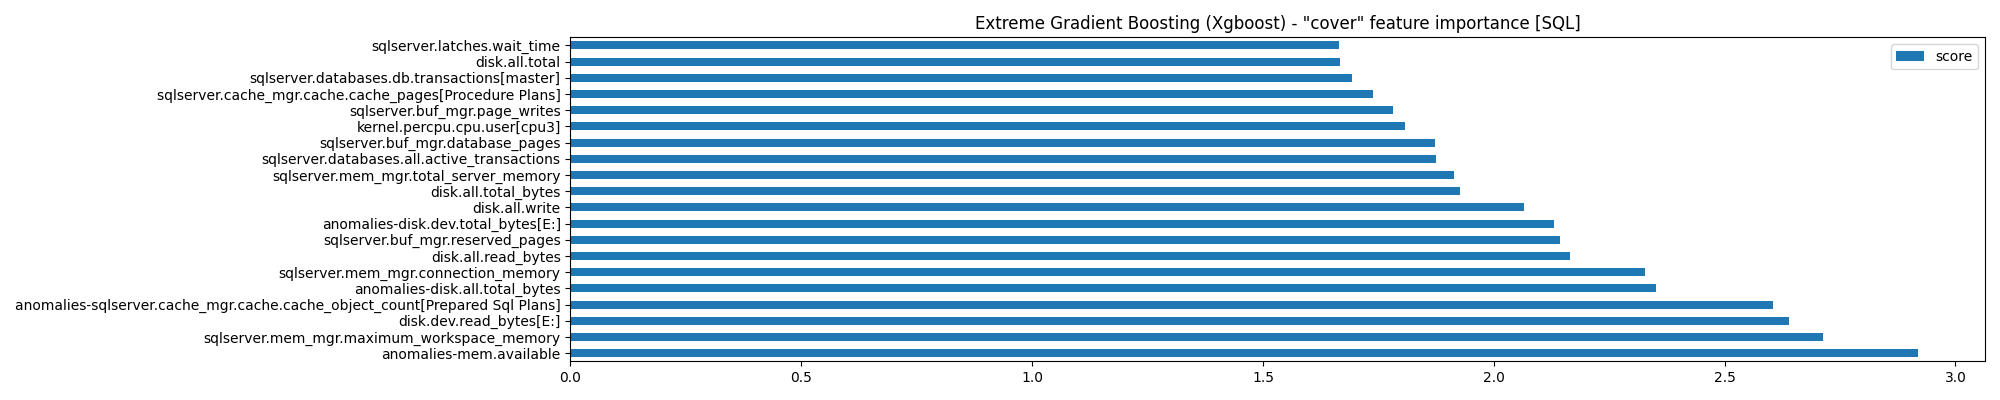

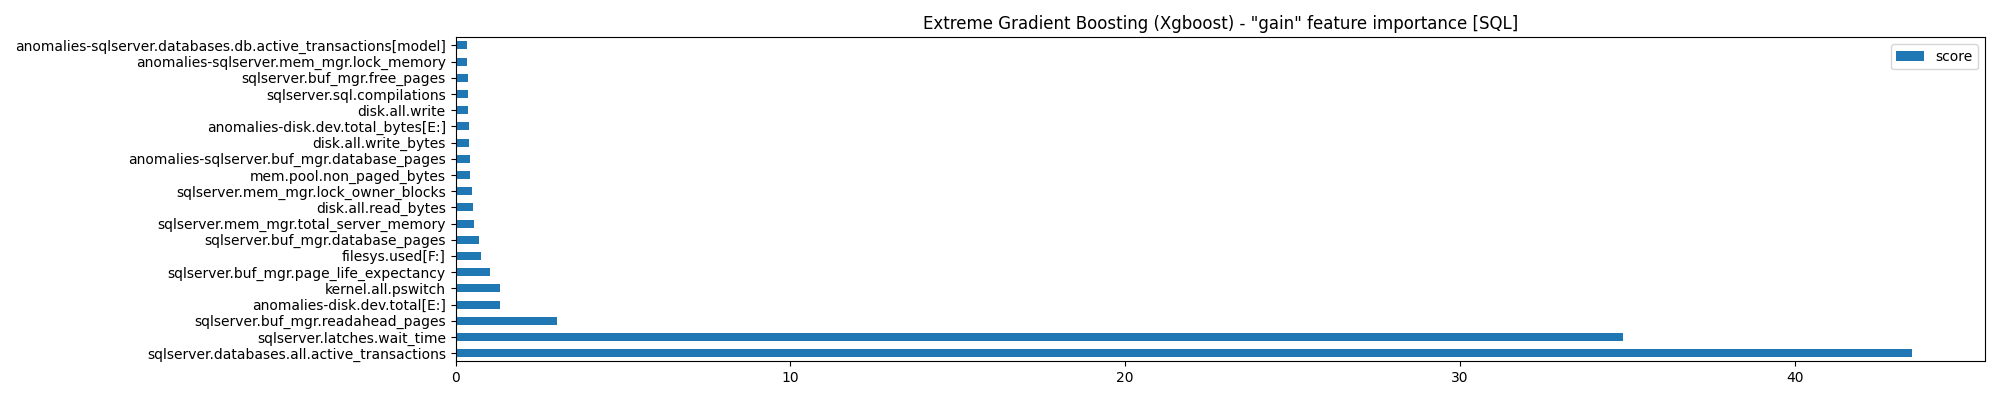

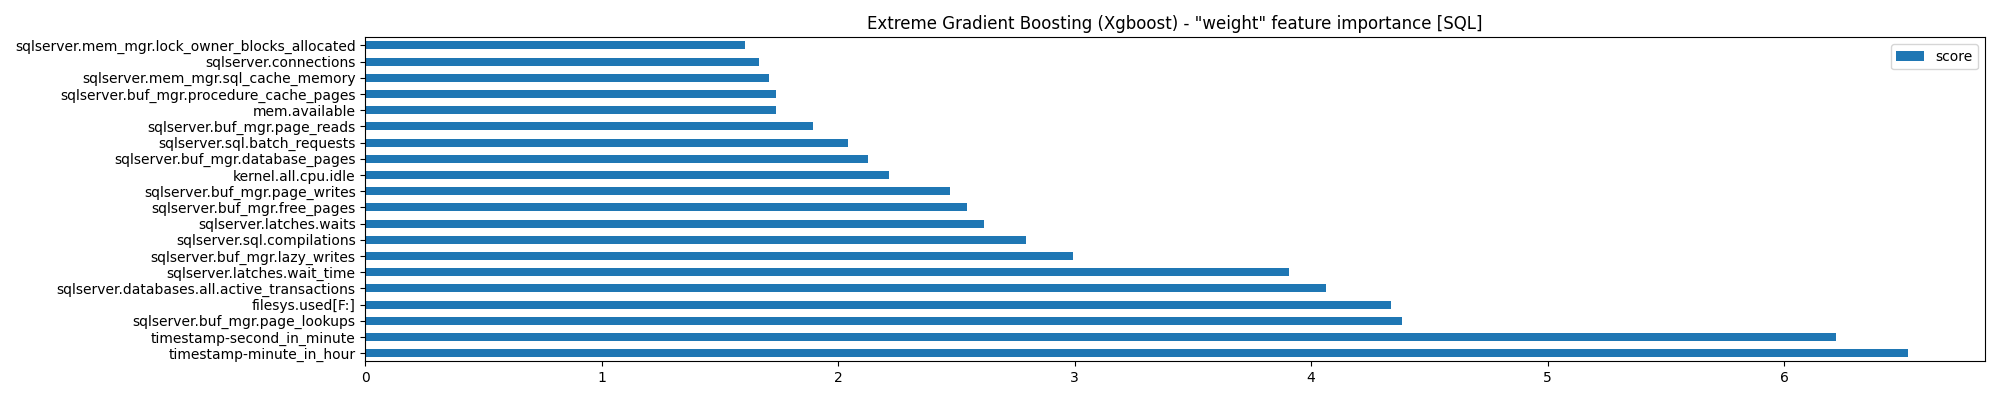

In [384]:
# importance types: e.g. 'weight', 'gain' or 'cover'
def plot_importance(filename, learner, importance_type='gain', top_N=20):
    if learner.algorithm_short_name != 'Xgboost':
        return False  # model must provide get_score()
    feature_importance = learner.model.get_score(importance_type=importance_type)

    total = 0
    for importance in feature_importance.values():
        total += importance

    values = []
    columns = []  # remap internal fN names to original features (by index) 
    for key, value in feature_importance.items():
        index = int(key[1:])
        columns.append(test_X.columns[index])
        values.append((value / total) * 100)

    data = pd.DataFrame(data=values, index=columns, columns=["score"]).sort_values(by = "score", ascending=False)
    data.nlargest(top_N, columns="score").plot(kind='barh', figsize = (20, 4)) ## plot top N features
    title = learner.algorithm_name + ' (' + learner.algorithm_short_name + ')'
    title += ' - "' + importance_type + '" feature importance [' + dataset + ']'
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close("all")
    return True

learner = best_model.learners[-1]
for importance in ['cover', 'gain', 'weight']:
    filename = 'images/' + learner.algorithm_short_name + '_top20_' + importance + '.png'
    if plot_importance(filename, learner, importance):
        display(Image(filename=filename))

## Plot results across rolling window model evaluations

In [385]:
def plot_algorithm_suitability(filename, best_algorithms):
    best_scores = sorted(best_algorithms.items(), key=lambda x:x[1], reverse=False)
    plt.figure(figsize=(5, 5))
    plt.barh(*zip(*best_scores))
    plt.title("Most Suitable Algorithm - Type [" + dataset + "]")
    plt.tight_layout(pad=2.0)
    plt.savefig(filename)
    plt.close("all")

if len(algorithms) > 1:
    plot_algorithm_suitability("images/best_scores.png", best_algorithm)
    display(Image(filename="images/best_scores.png"))

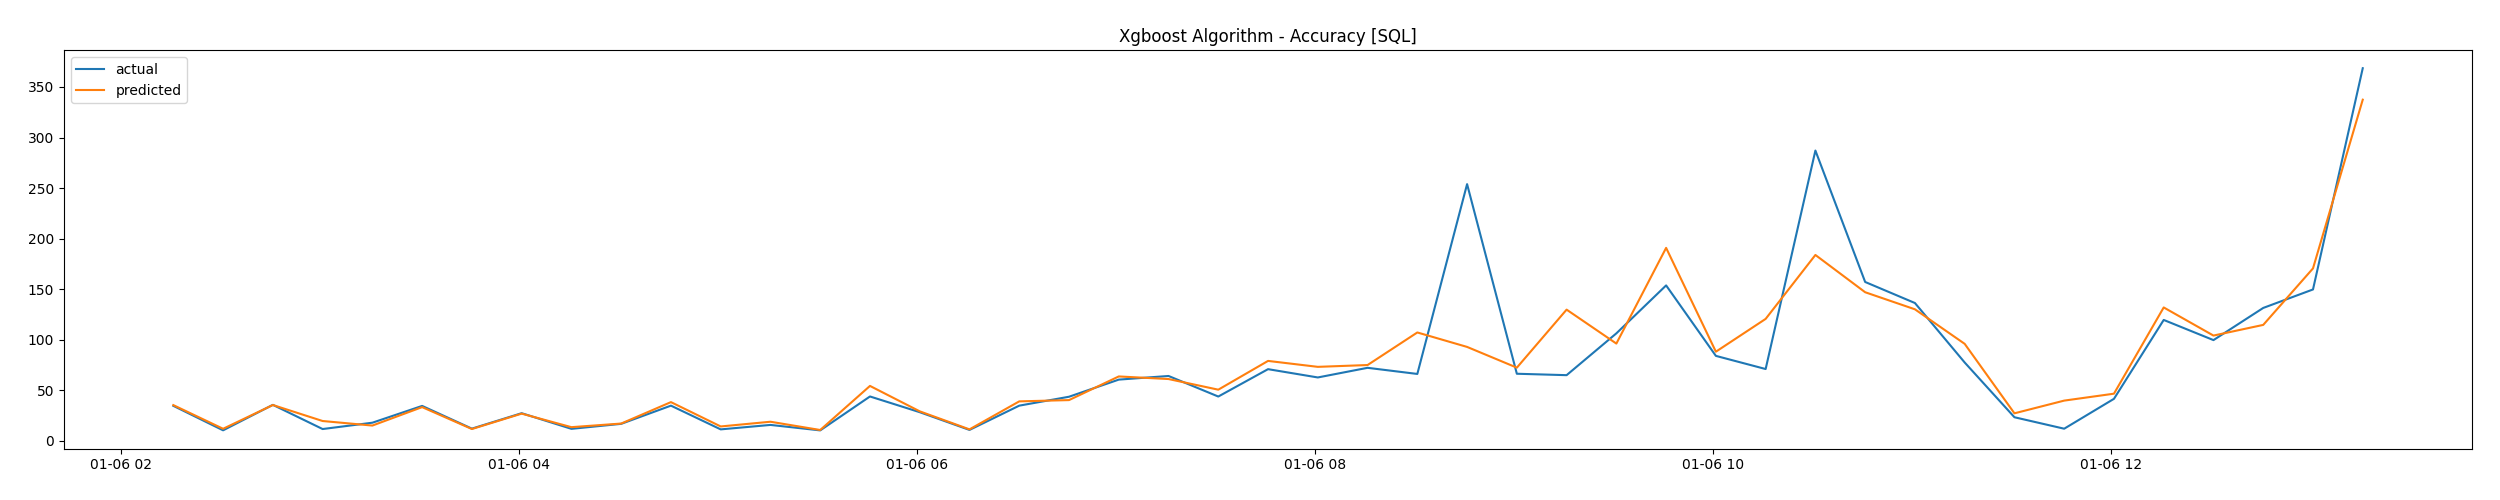

In [386]:
def plot_prediction_accuracies(filename, title, times, goals, preds):
    plt.figure(figsize=(25, 5))
    plt.plot(times, goals)
    plt.plot(times, preds)
    plt.legend(["actual", "predicted"])
    plt.title(title)
    plt.tight_layout(pad=2.0)
    plt.savefig(filename)
    plt.close("all")

if len(algorithms) == 1:
    filename = 'images/' + algorithms[0] + "_accuracy.png"
    title = algorithms[0] + " Algorithm - Accuracy [" + dataset + "]"
else:
    filename = "images/automl_accuracy.png"
    title = "Most Suitable Algorithm - Accuracy [" + dataset + "]"
plot_prediction_accuracies(filename, title, time_stamps, goal_values, pred_values)
display(Image(filename=filename))

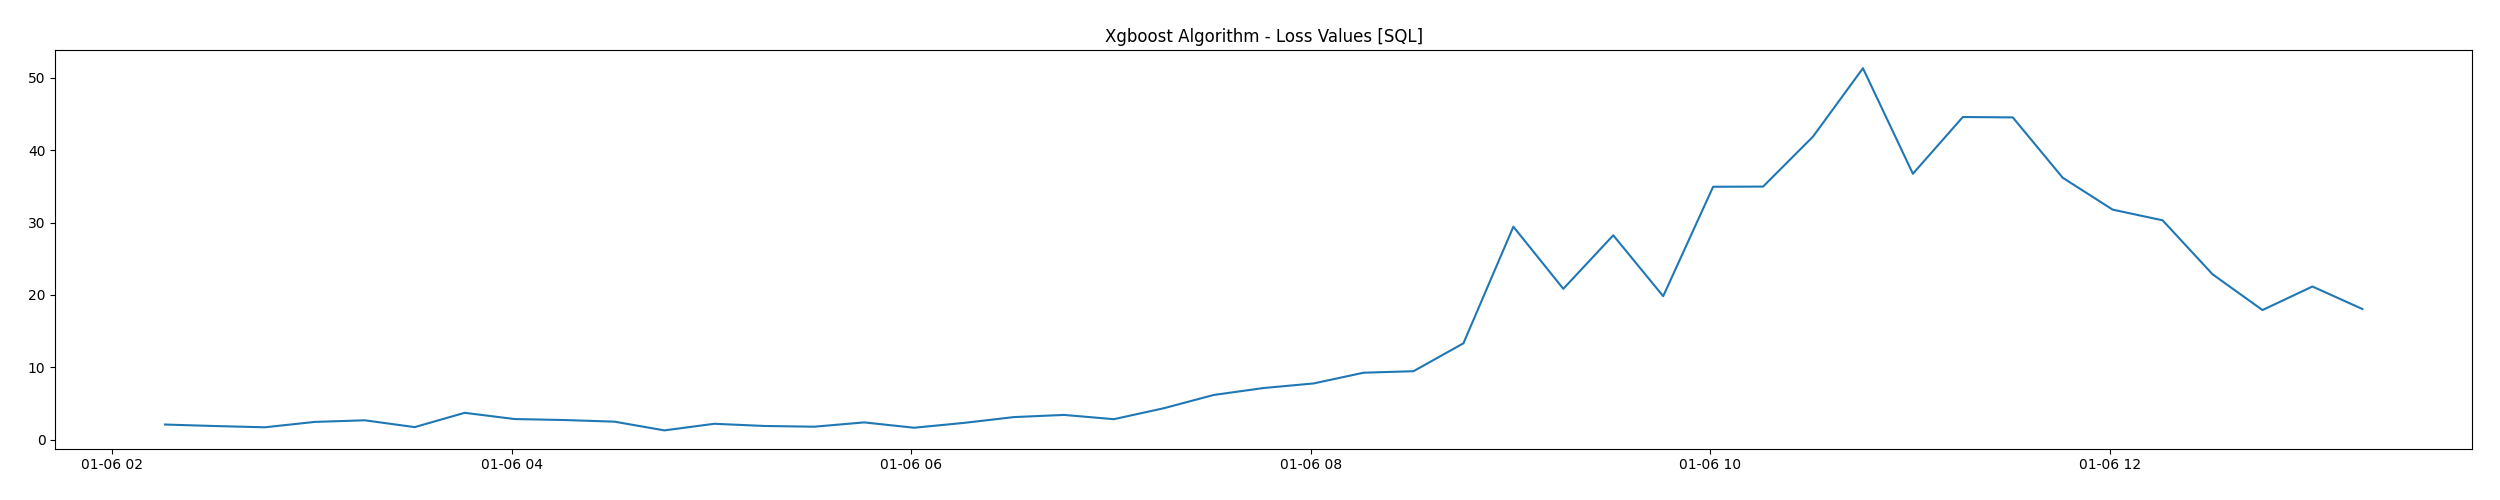

In [387]:
def plot_loss_values(filename, title, times, losses):
    plt.figure(figsize=(25, 5))
    plt.plot(times, losses)
    plt.title(title)
    plt.tight_layout(pad=2.0)
    plt.savefig(filename)
    plt.close("all")

if len(algorithms) == 1:
    filename = 'images/' + algorithms[0] + "_loss_values.png"
    title = algorithms[0] + " Algorithm - Loss Values [" + dataset + "]"
else:
    filename = "images/automl_loss_values.png"
    title = "Most Suitable Algorithm - Loss Values [" + dataset + "]"
plot_loss_values(filename, title, time_stamps, loss_values)
display(Image(filename=filename))

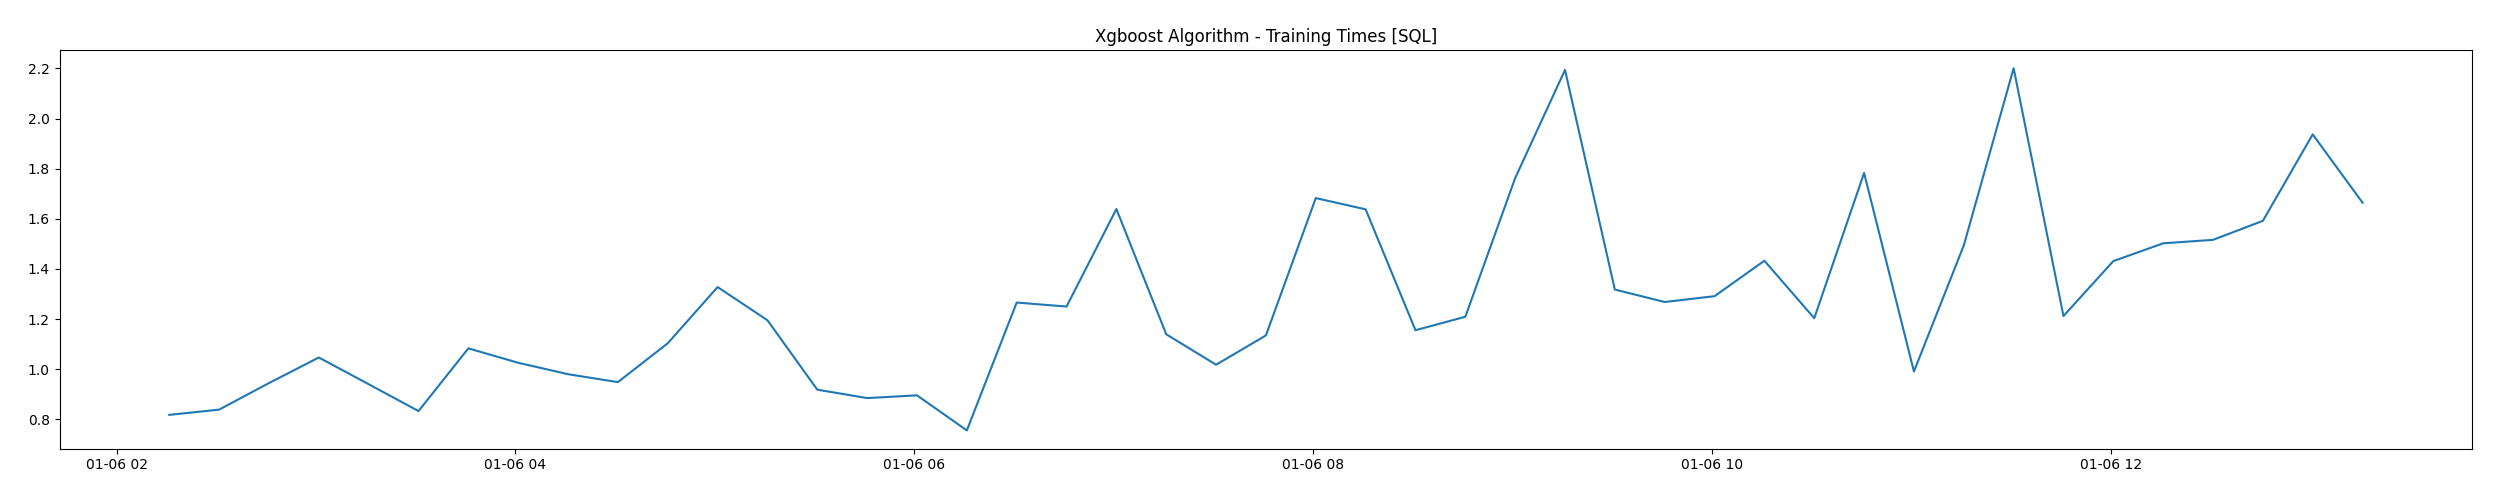

In [388]:
def plot_training_times(filename, title, epoch_times, train_times):
    plt.figure(figsize=(25, 5))
    plt.plot(epoch_times, train_times)
    plt.title(title)
    plt.tight_layout(pad=2.0)
    plt.savefig(filename)
    plt.close("all")

if len(algorithms) == 1:
    filename = 'images/' + algorithms[0] + "_train_times.png"
    title = algorithms[0] + " Algorithm - Training Times [" + dataset + "]"
else:
    filename = "images/automl_train_times.png"
    title = "Most Suitable Algorithm - Training Times [" + dataset + "]"
plot_training_times(filename, title, time_stamps, train_times)
display(Image(filename=filename))

## Permutation-based optimisation exploration

In [389]:
test_y

,sqlserver.databases.all.transactions
476,368.533333


In [390]:
test_X.shape

(1, 145)

In [391]:
train_y.shape

(476, 1)

In [392]:
train_X.shape

(476, 145)

In [393]:
timestamp

Timestamp('2009-01-06 13:15:49.163735')

In [394]:
# for each column, take max/min for that column and use it to perturb
# the single row test set then run prediction for each updated column

In [395]:
maxima = train_X.max().to_frame().T
minima = train_X.min().to_frame().T

In [396]:
maxima.shape

(1, 145)

In [397]:
count = test_X.shape[1]
testy = test_y.loc[test_y.index.repeat(count)].reset_index(drop=True)
maxdf = test_X.loc[test_X.index.repeat(count)].reset_index(drop=True)
mindf = maxdf.copy()  # contents are the same before perturbation

In [398]:
maxdf.shape

(145, 145)

In [399]:
# perturb one feature in each row
for i, column in enumerate(test_X):
    maxdf.at[i, column] = maxima[column][0]
    mindf.at[i, column] = minima[column][0]
    #print(i, column, minima[column][0], maxima[column][0]) -- dump column/min/max

Observed: 368.53333333
Predicted: 337.41815592
                                               feature     observe  \
0                           timestamp-second_in_minute  368.533333   
1                             timestamp-minute_in_hour  368.533333   
2                                timestamp-hour_in_day  368.533333   
3                                timestamp-day_of_week  368.533333   
4                                     filesys.used[C:]  368.533333   
..                                                 ...         ...   
140             anomalies-sqlserver.sql.batch_requests  368.533333   
141                   anomalies-disk.dev.queue_len[F:]  368.533333   
142            anomalies-sqlserver.mem_mgr.lock_memory  368.533333   
143  anomalies-sqlserver.databases.db.active_transa...  368.533333   
144            anomalies-sqlserver.buf_mgr.page_writes  368.533333   

        predict     minimum     maximum  
0    337.418156  352.659336  337.418156  
1    337.418156  337.418156 

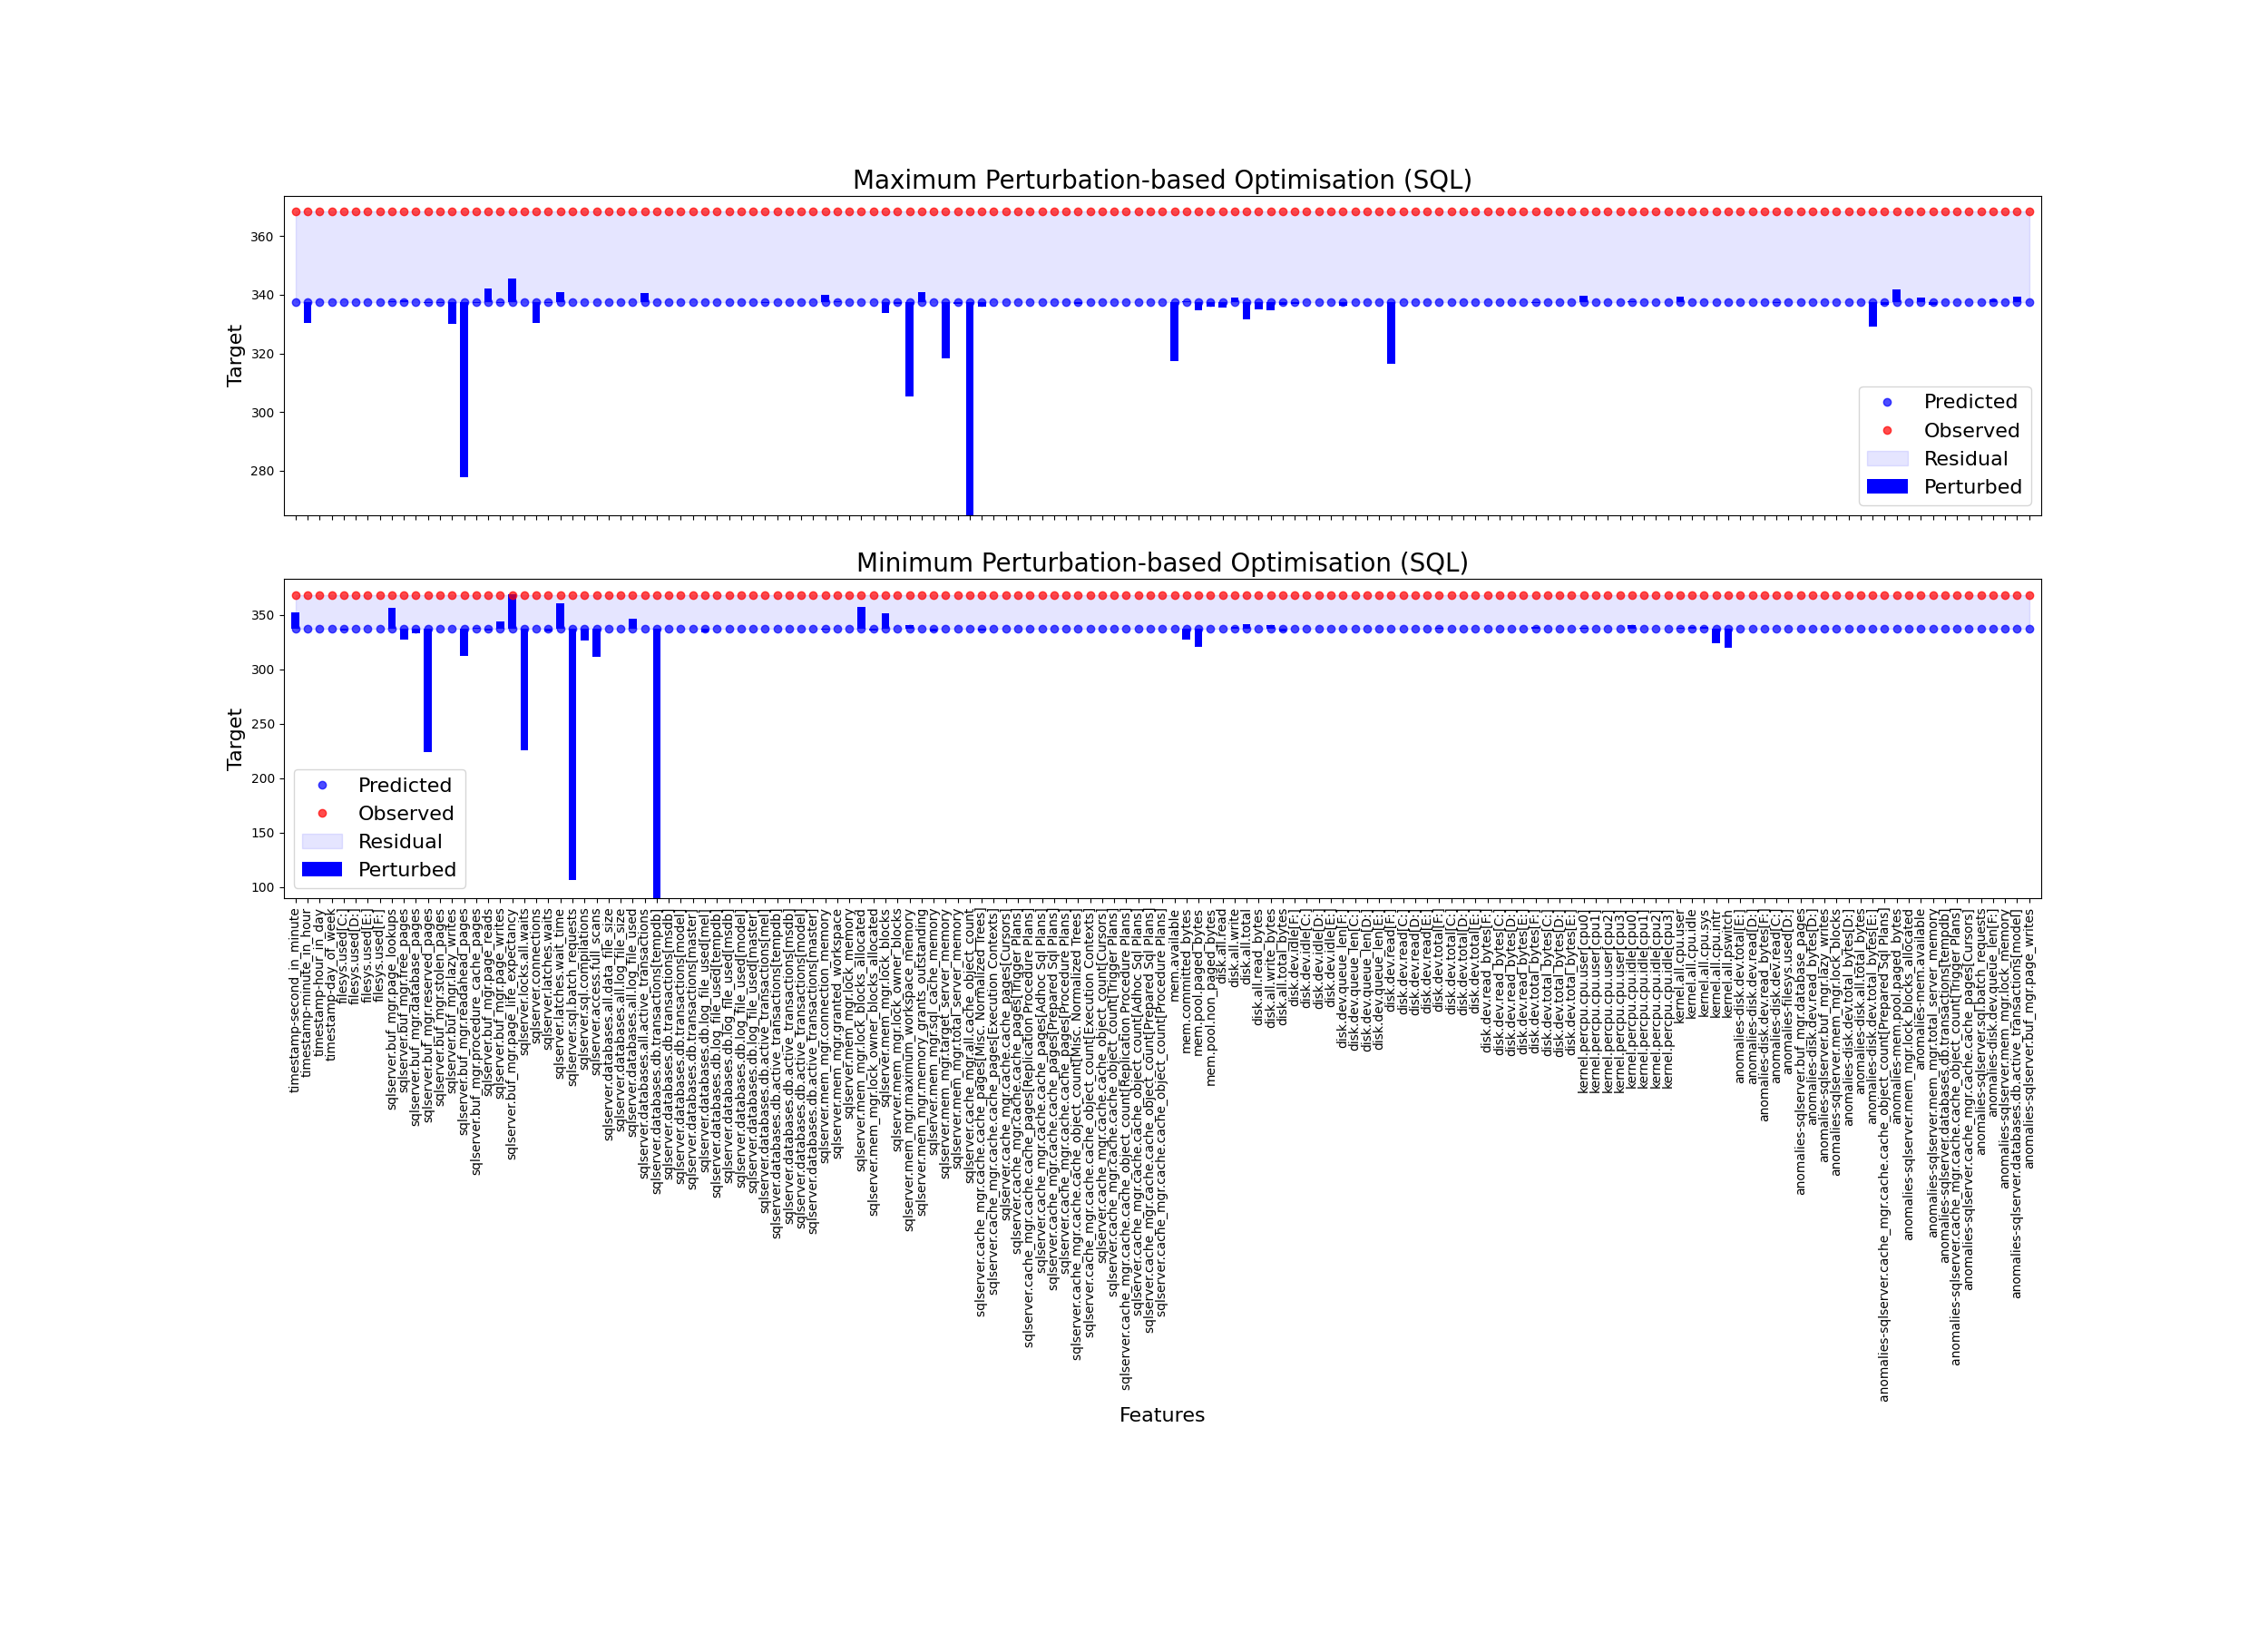

In [400]:
def predict_perturbed(filename, model, target, test_X, test_y, mindf, maxdf, testy):

    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        pred_y = model.predict(test_X)
        pred_all_y = pred_y.repeat(count)
        pred_min_y = model.predict(mindf)
        pred_max_y = model.predict(maxdf)

    nfeatures = test_X.shape[1]
    perturbed = pd.DataFrame({
        'feature': test_X.columns.values,
        'observe': test_y.iloc[-1][target].repeat(nfeatures),
        'predict': pred_y.repeat(nfeatures),
        'minimum': pred_min_y,
        'maximum': pred_max_y,
    })

    observed = test_y.iloc[-1][target]
    predicted = pred_y[0]
    if verbose:
        print('Observed: %.8f' % (observed))
        print('Predicted: %.8f' % (predicted))
        print(perturbed)

    max_inc = perturbed[perturbed.maximum > perturbed.predict]
    max_dec = perturbed[perturbed.maximum < perturbed.predict]
    min_inc = perturbed[perturbed.minimum > perturbed.predict]
    min_dec = perturbed[perturbed.minimum < perturbed.predict]

    (MEDIUM_FONT, LARGE_FONT) = (16, 20)
    fig, axs = plt.subplots(figsize=(25, 18), nrows=2, ncols=1, sharex=True)
    features = np.arange(nfeatures)
    width = 0.65

    axs[0].set_title("Maximum Perturbation-based Optimisation (" + dataset + ")", fontsize=LARGE_FONT)
    # Plot the increases from maxima perturbation
    axs[0].bar(max_inc.index, max_inc.maximum-max_inc.predict, width, bottom=max_inc.predict, color='b')
    # Plot the decreases from maxima perturbation
    axs[0].bar(max_dec.index, max_dec.predict-max_dec.maximum, width, bottom=max_dec.maximum, color='b')

    axs[1].set_title("Minimum Perturbation-based Optimisation (" + dataset + ")", fontsize=LARGE_FONT)
    # Plot the increases from minima perturbation
    axs[1].bar(min_inc.index, min_inc.minimum-min_inc.predict, width, bottom=min_inc.predict, color='b')
    # Plot the decreases from minima perturbation
    axs[1].bar(min_dec.index, min_dec.predict-min_dec.minimum, width, bottom=min_dec.minimum, color='b')

    for i in [0, 1]:
        axs[i].plot(features, perturbed.predict, 'bo', alpha=0.7)
        axs[i].plot(features, perturbed.observe, 'ro', alpha=0.7)
        axs[i].fill_between(features, observed, predicted, color='b', alpha=0.1)
        axs[i].set_xlim((-1, nfeatures))
        axs[i].set_ylabel("Target", fontsize=MEDIUM_FONT)
        axs[i].legend(["Predicted", "Observed", "Residual", "Perturbed"], fontsize=MEDIUM_FONT)

    plt.xlabel("Features", fontsize=MEDIUM_FONT)
    if len(test_X.columns.values) > 250:
        plt.xticks(features, [])
    else:
        plt.xticks(features, test_X.columns.values, rotation=90)
    fig.subplots_adjust(bottom=0.45)
    plt.savefig(filename)
    plt.close("all")

filename = 'images/perturbed-feature-optimisation-' + dataset.lower() + '.png'
predict_perturbed(filename, automl_model, targets[0], test_X, test_y, mindf, maxdf, testy)
display(Image(filename=filename))